In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from functions_garch import *

In [7]:
sm = ps.StanModel(file="garch_WB.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0ef85016fbe1114f4bfb9978c846a08 NOW.


In [23]:
T = 2000
p = 5
q = 3
d = 10
X = npr.randn(d,T)
omega = npr.rand()
beta = npr.rand(p)/(1.2*p)
alpha = npr.rand(q)/(1.2*q)
b = npr.randn(d)

In [24]:
sigsq, y = simulate_data(T, omega, beta, alpha, b, X)

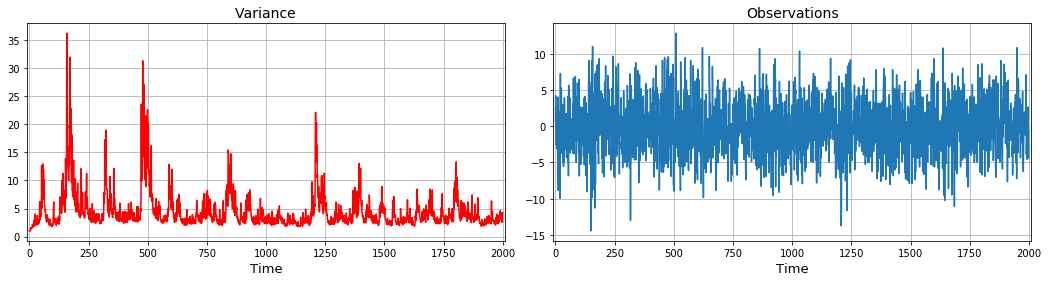

In [29]:
fig = plt.figure(figsize=(18,4))
plt.subplot(121)
plt.plot(sigsq, color="red")
plt.xlim(-0.005*T,1.005*T)
plt.title("Variance", fontsize=14)
plt.xlabel("Time", fontsize=13)
plt.grid(True)

plt.subplot(122)
plt.plot(y)
plt.xlim(-0.005*T,1.005*T)
plt.title("Observations", fontsize=14)
plt.xlabel("Time", fontsize=13)
plt.grid(True)

plt.subplots_adjust(wspace=1e-1)
fig.savefig('garch_data.pdf', bbox_inches='tight', dpi=2000)

### MCMC on full dataset:

In [26]:
n_chains = 10

data = dict(T=T, p=p, q=q, r=max(p,q), d=d, y=y, X=X, power=1.)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
mle = sm.optimizing(data=data)
print(round((time()-start)/60,2), "minutes to run")

file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "wb")
trace = fit.extract()
pickle.dump(fit.extract(), file)
file.close()

file = open("/xtmp/DC-BATS_data/garch/full_mle.pkl", "wb")
pickle.dump(mle, file)
file.close()

8.98 minutes to run


### Divide-and-conquer:

In [27]:
m = 10
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [28]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    data = dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=T/(tend-tstart))
    
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(fit.extract(), file)
    file.close()
    
    mle = sm.optimizing(data=data)
    file = open("/xtmp/DC-BATS_data/garch/mle_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(mle, file)
    file.close()